In this notebook we show how to run a simple deep learning model to classify whale calls. We use the [keras](https://keras.io/) library. We will use a convolutional neural networks, since they are robust to temporal and spatial shifts. Although it is common to use 2D convolutional model on the spectrogram, we will use a 1D on the time series, as this can be applied to other time series classification problems. But instead of raw data, we will use Welch-filtered signals.

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# importing multiple visualization libraries
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
import pylab as pl
import seaborn

In [3]:
# importing libraries to manipulate the data files
import os
from glob import glob

In [4]:
# import a library to read the .aiff format
import aifc

In [5]:
filenames = glob(os.path.join('../../../whale_data','train','*.aiff'))

In [6]:
from scipy import signal

In [7]:
# read signals and apply the welch filter
feature_dict = {}
fs = 2000
for filename in filenames[::1]:
    aiff = aifc.open(filename,'r')
    whale_strSig = aiff.readframes(aiff.getnframes())
    whale_array = np.fromstring(whale_strSig, np.short).byteswap()
    # apply welch filter
    feature = 10*np.log10(signal.welch(whale_array, fs=fs, window='hanning', nperseg=256, noverlap=128+64)[1])
    feature_dict[filename] = feature

In [8]:
import pandas as pd
X = pd.DataFrame(feature_dict).T

In [9]:
# Deep learning on time domain samples.
from __future__ import division
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard

Using TensorFlow backend.


In [10]:
#y = np.array(labels['label'][X.columns])
y = np.load('y.npy')
y = y.astype('float32')

In [11]:
from sklearn.model_selection import train_test_split
target_names = ['Upcall', 'NO_Upcall']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2018)

# Convert label to onehot
#y_train = keras.utils.to_categorical(y_train, num_classes=2)
#y_test = keras.utils.to_categorical(y_test, num_classes=2)

print(X_train.shape)
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

(24000, 129)


In [12]:
# Build the Neural Network
model = Sequential()

model.add(Conv1D(16, 3, activation='relu', input_shape=(129, 1)))
model.add(Conv1D(16, 3, activation='relu'))
model.add(BatchNormalization())

model.add(Conv1D(32, 3, activation='relu'))
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling1D(2))
model.add(Conv1D(64, 3, activation='relu'))
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling1D(2))
model.add(Conv1D(128, 3, activation='relu'))
model.add(Conv1D(128, 3, activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling1D(2))
model.add(Conv1D(256, 3, activation='relu'))
model.add(Conv1D(256, 3, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling1D())

model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=0.01),
              metrics=['accuracy'])




model_name = 'deep_1'
top_weights_path = 'model_' + str(model_name) + '.h5'

callbacks_list = [ModelCheckpoint(top_weights_path, monitor = 'val_acc', verbose = 1, save_best_only = True, save_weights_only = True), 
    EarlyStopping(monitor = 'val_acc', patience = 6, verbose = 1),
    ReduceLROnPlateau(monitor = 'val_acc', factor = 0.1, patience = 3, verbose = 1),
    CSVLogger('model_' + str(model_name) + '.log')]

We see a lot of jargon:

|Term| Explanation|
|---|---|
|Convolutional Layers | layers which are robust to time shifts|
|Max Pooling/ Average Pooling |dimension reduction, robustness|
|Batch normalization |equalizes the distribution of the batches |
|Epochs |1 run of a batch |
|Adam Optimizer | an adaptive optimization scheme|
|Cross Entropy | cost function|
|ReLU | nonlinear activation function| 
|Batch Size| size of subset to process to update the estimates|
|Learning Rate | time step of the optimization algorithm|

In [13]:
#from keras.utils import plot_model
#plot_model(model,to_file='model_plot.png')

<img src="img/model_plot.png" width=200/>

In [14]:
%%time
# Fitting the Model (this will take a loooooooot of time)
model.fit(X_train, y_train, batch_size=128, epochs=100, validation_data = [X_test, y_test], callbacks = callbacks_list)

Train on 24000 samples, validate on 6000 samples
Epoch 1/100
24000/24000 [==============================] - 19s 790us/step - loss: 0.5631 - acc: 0.7075 - val_loss: 0.4349 - val_acc: 0.8143

Epoch 00001: val_acc improved from -inf to 0.81433, saving model to model_deep_1.h5
Epoch 2/100
24000/24000 [==============================] - 18s 749us/step - loss: 0.4043 - acc: 0.8227 - val_loss: 0.3864 - val_acc: 0.8337

Epoch 00002: val_acc improved from 0.81433 to 0.83367, saving model to model_deep_1.h5
Epoch 3/100
24000/24000 [==============================] - 18s 771us/step - loss: 0.3566 - acc: 0.8456 - val_loss: 0.4442 - val_acc: 0.7998

Epoch 00003: val_acc did not improve from 0.83367
Epoch 4/100
24000/24000 [==============================] - 19s 801us/step - loss: 0.3349 - acc: 0.8545 - val_loss: 0.3362 - val_acc: 0.8485

Epoch 00004: val_acc improved from 0.83367 to 0.84850, saving model to model_deep_1.h5
Epoch 5/100
24000/24000 [==============================] - 20s 828us/step - los

KeyboardInterrupt: 

#### Evaluation

In [15]:
model.load_weights(top_weights_path)
loss, acc = model.evaluate(X_test, y_test, batch_size=16)
print('Test accuracy:', acc)

6000/6000 [==============================] - 3s 478us/step
Test accuracy: 0.8633333333333333


In [16]:
# predict
y_pred = model.predict(X_test)

In [17]:
# precision
sum(y_pred[y_test == 1]>.1)/len(y_test == 1)

array([0.221])

In [18]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test.astype('int'), y_pred)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.75


Text(0.5,1,'2-class Precision-Recall curve: AP=0.75')

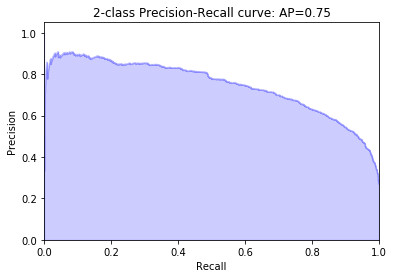

In [19]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test.astype('int'), y_pred)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

**References:**

[Deep Learning Glossary](http://www.wildml.com/deep-learning-glossary/)

[Keras and NN Tutorial](https://indico.cern.ch/event/506145/contributions/2132944/attachments/1258124/1858154/NNinKeras_MPaganini.pdf)

[Keras Cheatsheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Keras_Cheat_Sheet_Python.pdf)

Free GPU usage: [Google Colaboratory notebooks](https://colab.research.google.com/notebooks/welcome.ipynb#recent=true) & [Kaggle Kernels](https://www.kaggle.com/kernels).